# Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Rescaling
from keras.models import Sequential
from keras.optimizers import Adam

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

#ML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Load Data

In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory('data/covid/train/', color_mode='grayscale', seed=42, shuffle=False)
val_ds = tf.keras.utils.image_dataset_from_directory('data/covid/validation/', color_mode='grayscale', seed=42, shuffle=False)
test_ds = tf.keras.utils.image_dataset_from_directory('data/covid/test/', color_mode='grayscale', seed=42, shuffle=False)


Found 339 files belonging to 3 classes.
Found 42 files belonging to 3 classes.
Found 45 files belonging to 3 classes.


In [3]:
class_names = train_ds.class_names
class_names

['COVID-19', 'HEALTHY', 'PNEUMONIA']

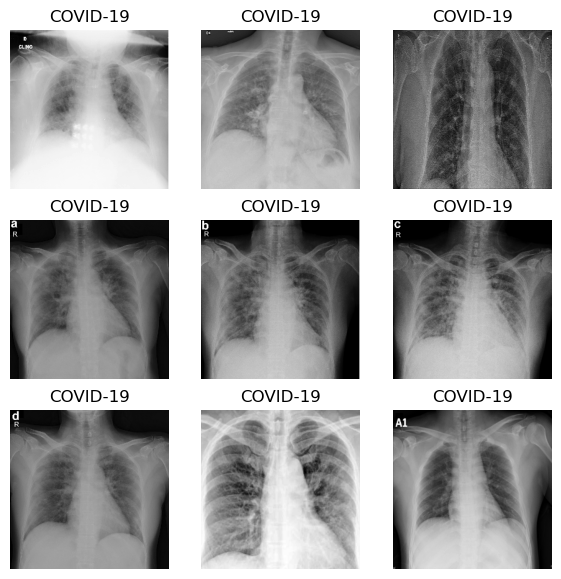

In [4]:
# Display image samples
plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [5]:
# Image shapes
images[i].shape

TensorShape([256, 256, 1])

# Classical ML


For working with classical ML algorithms we need some kind of matrix or DataFrame format for representing the features.

The function below transforms images to a pandas DataFrame.

In [6]:
def get_images_df(image_dataset):
    # get images from dataset in DF format
    df = []
    all_labels = []
    for images, labels in image_dataset:
        for img in images:
            flat_img = tf.keras.preprocessing.image.img_to_array(img, data_format=None, dtype=None).flatten()
            df.append(flat_img)
        all_labels.extend(labels.numpy())
    df = pd.DataFrame(df)
    df['label'] = all_labels
    return df

## Train / Test

In [7]:
# Convert train, validation and test images to DF
df_train = get_images_df(train_ds)
df_val = get_images_df(val_ds)
df_test = get_images_df(test_ds)

In [8]:
print(df_train.shape)
df_train.head()

(339, 65537)


,0,1,2,3,4,5,6,7,8,9,...,65527,65528,65529,65530,65531,65532,65533,65534,65535,label
0,133.446396,124.478516,116.227005,117.622932,115.250984,114.443260,115.816406,114.301094,116.669922,118.816406,...,232.000000,229.224304,227.000000,224.091705,222.182617,220.000000,216.635529,211.085938,254.000000,0
1,50.556885,51.687500,50.000000,49.664307,49.062256,50.000000,50.000000,49.103760,49.000000,48.830811,...,162.312500,158.583740,157.260498,155.089844,157.625244,155.312500,152.222656,153.933594,150.241699,0
2,41.938568,47.705780,52.086197,54.049973,58.179764,55.633804,59.620987,53.624222,57.861038,53.714249,...,94.434967,78.643753,84.353516,78.782211,82.050629,70.695786,71.030334,84.028748,87.266510,0
3,11.279842,12.771484,12.028118,9.754784,12.468697,12.794781,11.542667,12.769428,15.005844,11.304844,...,9.631351,10.486698,9.000000,9.000000,10.000000,11.000000,11.000000,11.000000,8.529297,0
4,0.232422,0.505272,4.974266,2.320724,0.117378,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.289062,251.644531,0


In [9]:
df_train["label"].value_counts()

0    113
1    113
2    113
Name: label, dtype: int64

In [10]:
# We can subsample the train data to train faster
df_train_sub = df_train.sample(100, random_state=42)
X_train = df_train_sub.drop('label', axis=1)
y_train = df_train_sub['label']

X_val = df_val.drop('label', axis=1)
y_val = df_val['label']

X_test = df_test.drop('label', axis=1)
y_test = df_test['label']

def repeat_split():
    df_train_sub = df_train.sample(100, random_state=42)
    X_train = df_train_sub.drop('label', axis=1)
    y_train = df_train_sub['label']

    X_val = df_val.drop('label', axis=1)
    y_val = df_val['label']

    X_test = df_test.drop('label', axis=1)
    y_test = df_test['label']

In [11]:
# Declare scores to be used
scoring = {
    'Acc': make_scorer(accuracy_score),
}

In [12]:
def print_metrics(cv_results):
    for sc in scoring.keys():
        print(f'Train {sc}:', cv_results[f'train_{sc}'].mean().round(2))
    print()
    ''' for sc in scoring.keys():
        print(f'Validation {sc}:', cv_results[f'test_{sc}'].mean().round(2))'''

        
def print_metrics_rs(rand_search, idx=None):
    if idx is None:
        idx = rand_search.best_index_
    for sc in scoring.keys():
        print(f'Train {sc}:', rand_search.cv_results_[f'mean_train_{sc}'][idx].round(2))
    print()
    '''for sc in scoring.keys():
        print(f'Validation {sc}:', rand_search.cv_results_[f'mean_test_{sc}'][idx].round(2))'''

## Baseline 1

In [13]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import  cross_validate

In [28]:
bl = DummyClassifier(strategy='most_frequent')
bl_cv = cross_validate(bl, X_train, y_train,
                       scoring=scoring, return_train_score=True)

print_metrics(bl_cv)

bl_cv = cross_validate(bl, X_val, y_val,
                       scoring=scoring, return_train_score=True)
print("Val train")
print_metrics(bl_cv)

Train Acc: 0.35

Val train
Train Acc: 0.35



## Baseline 2

In [30]:
bl2 = LogisticRegression(max_iter=10_000)
bl2_cv = cross_validate(bl2, X_train[[1]], y_train,
                        scoring=scoring, return_train_score=True)

print_metrics(bl2_cv)

bl2 = LogisticRegression(max_iter=10_000)
bl2_cv = cross_validate(bl2, X_val[[1]], y_val,
                        scoring=scoring, return_train_score=True)

print("Val train")
print_metrics(bl2_cv)

Train Acc: 0.43

Val train
Train Acc: 0.35



## Logistic Regression

In [25]:
lr = LogisticRegression(max_iter=10_000)
lr.fit(X_train, y_train)
y_tr_pred = lr.predict(X_train)
print("Train:", accuracy_score(y_train, y_tr_pred))

# Accuracy on validation set)
y_val_pred = lr.predict(X_val)
print("Validation:", accuracy_score(y_val, y_val_pred))

Train: 1.0
Validation: 0.8809523809523809


## K-Neighbours Classifier

In [26]:
param_dist = {
    "scale": [StandardScaler(), RobustScaler(), MinMaxScaler()],
    "knn__n_neighbors": [3, 5, 8, 10, 12, 15, 20],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2]
}

knn = Pipeline([
    ('scale', None),
    ('knn', KNeighborsClassifier(n_jobs=-1))
])

knn_rscv = RandomizedSearchCV(knn, param_distributions=param_dist,
                              scoring=scoring, return_train_score=True,
                              refit="Acc", n_jobs=-1)

knn_rscv.fit(X_train, y_train)

print("Mejores parámetros de RandomizedSearchCV: ", knn_rscv.best_params_)
print_metrics_rs(knn_rscv)

y_val_pred = knn_rscv.predict(X_val)
print("Validation:", accuracy_score(y_val, y_val_pred))

Mejores parámetros de RandomizedSearchCV:  {'scale': MinMaxScaler(), 'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': 8}
Train Acc: 1.0

Validation: 0.8809523809523809


## Decision Tree

In [29]:
param_dist = {
    "max_depth": [3, 5, 10, 20, 50, 100, None],
    "min_samples_split": np.arange(2, 11),
    "min_samples_leaf": np.arange(1, 11),    
    "criterion": ["entropy", "log_loss", "gini"]
}
dt = DecisionTreeClassifier()
dt_rscv = RandomizedSearchCV(dt, param_distributions=param_dist,
                             scoring=scoring, return_train_score=True,
                             n_iter=50, verbose=1,
                             refit="Acc", n_jobs=-1)

dt_rscv.fit(X_train, y_train)
print("Best RandomizedSearchCV parameters: ", dt_rscv.best_params_)
print_metrics_rs(knn_rscv)

y_val_pred = dt_rscv.predict(X_val)
print("Validation:", accuracy_score(y_val, y_val_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best RandomizedSearchCV parameters:  {'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 3, 'criterion': 'log_loss'}
Train Acc: 1.0

Validation: 0.6904761904761905


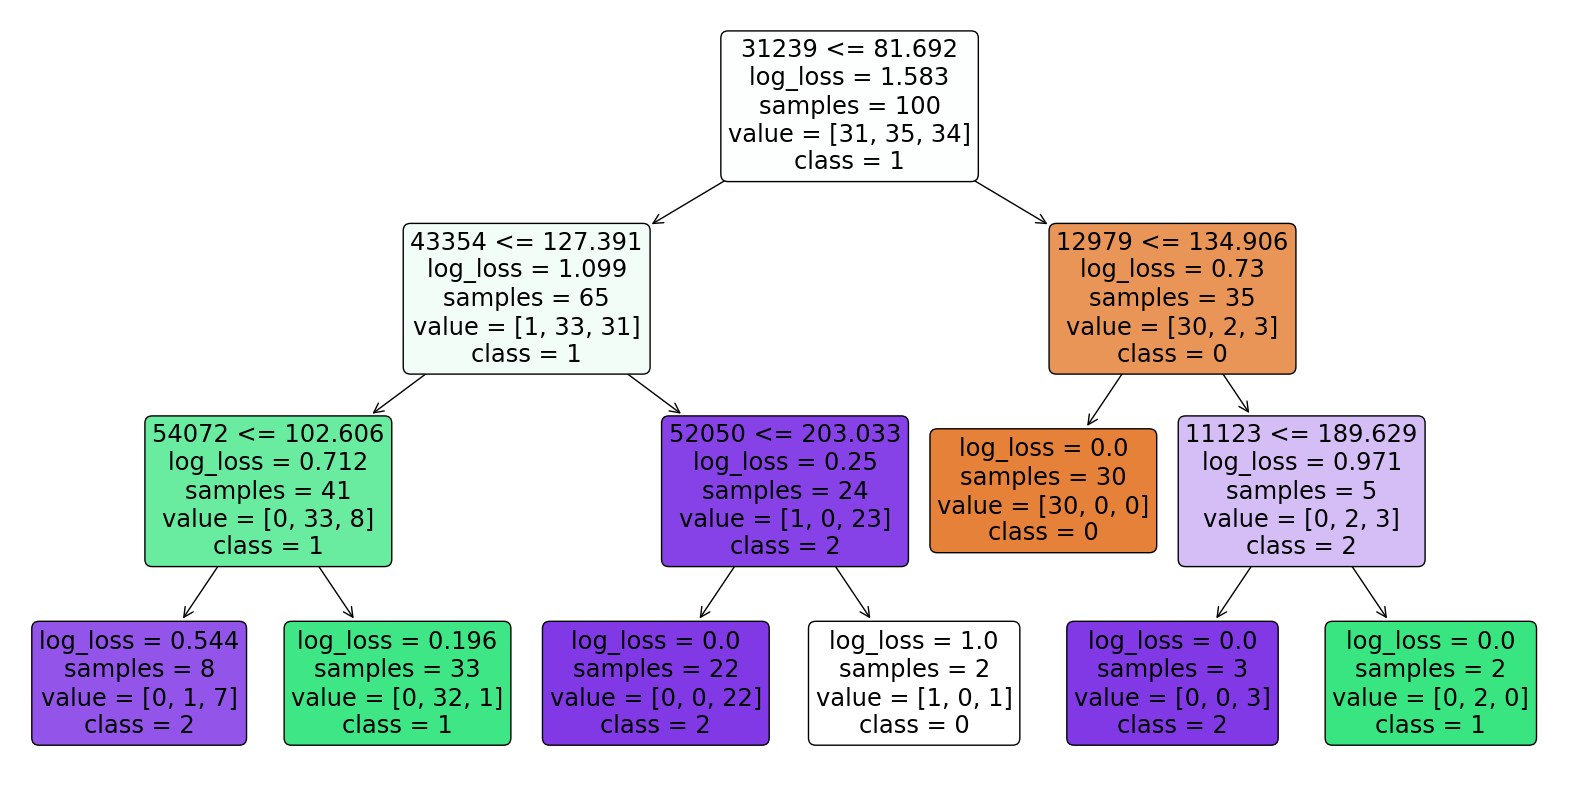

In [32]:
plt.figure(figsize=(20,10))
plot_tree(dt_rscv.best_estimator_, filled=True, feature_names=list(X_train.columns),
          class_names=['0', '1', '2'], rounded=True)
plt.show()

## Random Forest

In [15]:
param_dist = {
    "max_depth": [3, 5, 10, 20, 50, 100, None],
    "min_samples_split": np.arange(2, 30),
    "min_samples_leaf": np.arange(1, 11),
    "criterion": ["entropy", "log_loss", "gini"],
    "n_estimators": np.arange(2,200),
    "max_features": ["sqrt", "log2", 0.2, 0.4, 0.6, 0.8],  
    "bootstrap": [True, False]
}
rf = RandomForestClassifier(n_jobs=-1)
rf_rscv = RandomizedSearchCV(rf, param_distributions=param_dist,
                             scoring=scoring, return_train_score=True,
                             verbose=1, n_iter=50,
                             refit="Acc", n_jobs=-1)

rf_rscv.fit(X_train, y_train)
print("Best RandomizedSearchCV parameters: ", rf_rscv.best_params_)
print_metrics_rs(rf_rscv)

y_val_pred = rf_rscv.predict(X_val)
print("Validation:", accuracy_score(y_val, y_val_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
import seaborn as sb

In [ ]:
rf_rscv.best_estimator_.fit(X_train, y_train)

y_pred = rf_rscv.best_estimator_.predict(X_train)

micro_precision = precision_score(y_train, y_pred, average='micro')
micro_recall = recall_score(y_train, y_pred, average='micro')

print(f"Precicision Micro: {micro_precision}")
print(f"Recall Micro: {micro_recall}")

values = [0,1,2]
conf_matrix = confusion_matrix(y_train, y_pred)

plt.figure(figsize=(8,6))
sb.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=values, yticklabels=values)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Gradient Boosting Decision Tree

In [ ]:
param_dist = {
    "max_depth": [3, 5, 10, 20],
    "min_samples_split": np.arange(2, 30),
    "min_samples_leaf": np.arange(1, 11),
    "criterion": ["friedman_mse", "squared_error"],
    "n_estimators": np.arange(2,200),
    "max_features": ["sqrt", "log2", 0.2, 0.4, 0.6, 0.8], 
    "learning_rate": [ 0.01, 0.025, 0.05, 0.075, 0.1]
}
gb = GradientBoostingClassifier()
gb_rscv = RandomizedSearchCV(gb, param_distributions=param_dist,
                             scoring=scoring, return_train_score=True,
                            verbose=1, n_iter=50,
                             refit="Acc", n_jobs=-1)

gb_rscv.fit(X_train, y_train)
print("Best RandomizedSearchCV parameters: ", gb_rscv.best_params_)
print_metrics_rs(gb_rscv)

y_val_pred = gb_rscv.predict(X_val)
print("Validation:", accuracy_score(y_val, y_val_pred))

# Neural Network

### Softmax Neuron

In [52]:
# Define the NN model

model = Sequential([
    Input(X_train.shape[1]),
    Rescaling(1./255),
    Dense(784, activation='relu'),
    Dense(390, activation='relu'),
    # Dense(195, activation='relu'),
    # Dense(92, activation='relu'),
    # Dense(45, activation='relu'),
    Dense(22, activation='relu'),
    Dense(10, activation='softmax'),
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 784)               51381008  
                                                                 
 dense_1 (Dense)             (None, 390)               306150    
                                                                 
 dense_2 (Dense)             (None, 22)                8602      
                                                                 
 dense_3 (Dense)             (None, 10)                230       
                                                                 
Total params: 51695990 (197.20 MB)
Trainable params: 51695990 (197.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
from tensorflow.keras.callbacks import EarlyStopping

In [53]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

# Fit the model with the EarlyStopping callback
results = model.fit(X_train, y_train, epochs=75, batch_size=16, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/75
7/7 [==============================] - 4s 519ms/step - loss: 20.2926 - accuracy: 0.3400 - val_loss: 4.6224 - val_accuracy: 0.5952
Epoch 2/75
7/7 [==============================] - 3s 498ms/step - loss: 11.0665 - accuracy: 0.3400 - val_loss: 16.2234 - val_accuracy: 0.3333
Epoch 3/75
7/7 [==============================] - 3s 497ms/step - loss: 9.9216 - accuracy: 0.3500 - val_loss: 3.1012 - val_accuracy: 0.5476
Epoch 4/75
7/7 [==============================] - 3s 494ms/step - loss: 5.5745 - accuracy: 0.4500 - val_loss: 2.2102 - val_accuracy: 0.5000
Epoch 5/75
7/7 [==============================] - 3s 493ms/step - loss: 2.4801 - accuracy: 0.5400 - val_loss: 1.3416 - val_accuracy: 0.5714
Epoch 6/75
7/7 [==============================] - 3s 493ms/step - loss: 1.2193 - accuracy: 0.6400 - val_loss: 0.9934 - val_accuracy: 0.6190
Epoch 7/75
7/7 [==============================] - 3s 494ms/step - loss: 0.7458 - accuracy: 0.6600 - val_loss: 0.6595 - val_accuracy: 0.7619
Epoch 8/75
7/7 [=

## CNN

Keras can directly load data from a structure of directories, we don't need the pandas DataFrame we were using before.

The following example is not working well. Improve it! For example, adding more convolutional layer and/or more filters, etc.

In [105]:
cnn_model = Sequential([
    Input(shape=(256, 256, 1)),
    Rescaling(1./255),
    Conv2D(filters=16, kernel_size=2, strides=1, activation='relu'),
    Conv2D(filters=16, kernel_size=2, strides=1, activation='relu'),
    MaxPooling2D(pool_size=2, strides=None),
    Conv2D(filters=4, kernel_size=2, strides=1, activation='relu'),
    Conv2D(filters=4, kernel_size=2, strides=1, activation='relu'),
    MaxPooling2D(pool_size=2, strides=None),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

def repeat_model():
    cnn_model = Sequential([
        Input(shape=(256, 256, 1)),
        Rescaling(1./255),
        Conv2D(filters=16, kernel_size=2, strides=1, activation='relu'),
        Conv2D(filters=16, kernel_size=2, strides=1, activation='relu'),
        MaxPooling2D(pool_size=2, strides=None),
        Conv2D(filters=4, kernel_size=2, strides=1, activation='relu'),
        Conv2D(filters=4, kernel_size=2, strides=1, activation='relu'),
        MaxPooling2D(pool_size=2, strides=None),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(len(class_names), activation='softmax')
    ])

    cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return cnn_model

In [65]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_15 (Rescaling)    (None, 65536)             0         
                                                                 
 dense_34 (Dense)            (None, 784)               51381008  
                                                                 
 dense_35 (Dense)            (None, 390)               306150    
                                                                 
 dense_36 (Dense)            (None, 22)                8602      
                                                                 
 dense_37 (Dense)            (None, 10)                230       
                                                                 
Total params: 51695990 (197.20 MB)
Trainable params: 51695990 (197.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [66]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

# Fit the model with the EarlyStopping callback
results = cnn_model.fit(train_ds, validation_data=val_ds, epochs=50, batch_size=32, callbacks=[early_stopping])

Epoch 1/50
11/11 [==============================] - 4s 263ms/step - loss: 1.0958 - accuracy: 0.4100 - val_loss: 1.0469 - val_accuracy: 0.4048
Epoch 2/50
11/11 [==============================] - 3s 253ms/step - loss: 1.0060 - accuracy: 0.4248 - val_loss: 0.9070 - val_accuracy: 0.4762
Epoch 3/50
11/11 [==============================] - 3s 259ms/step - loss: 0.8508 - accuracy: 0.4690 - val_loss: 0.7435 - val_accuracy: 0.5476
Epoch 4/50
11/11 [==============================] - 3s 256ms/step - loss: 0.6894 - accuracy: 0.5575 - val_loss: 0.6206 - val_accuracy: 0.5714
Epoch 5/50
11/11 [==============================] - 3s 255ms/step - loss: 0.5489 - accuracy: 0.7788 - val_loss: 0.5259 - val_accuracy: 0.8333
Epoch 6/50
11/11 [==============================] - 3s 255ms/step - loss: 0.4375 - accuracy: 0.8879 - val_loss: 0.5669 - val_accuracy: 0.8333
Epoch 7/50
11/11 [==============================] - 3s 253ms/step - loss: 0.3952 - accuracy: 0.8909 - val_loss: 0.2861 - val_accuracy: 0.9048
Epoch 

In [106]:
cnn_model2 = repeat_model()

results = cnn_model2.fit(train_ds, validation_data=val_ds, epochs=30, batch_size=32, callbacks=[early_stopping])

Epoch 1/30
11/11 [==============================] - 4s 301ms/step - loss: 1.5359 - accuracy: 0.2389 - val_loss: 1.1169 - val_accuracy: 0.3333
Epoch 2/30
11/11 [==============================] - 3s 285ms/step - loss: 1.5147 - accuracy: 0.3333 - val_loss: 1.0905 - val_accuracy: 0.3333
Epoch 3/30
11/11 [==============================] - 3s 292ms/step - loss: 1.0931 - accuracy: 0.6667 - val_loss: 1.0969 - val_accuracy: 0.5238
Epoch 4/30
11/11 [==============================] - 3s 286ms/step - loss: 1.0984 - accuracy: 0.4012 - val_loss: 1.0936 - val_accuracy: 0.5476
Epoch 5/30
11/11 [==============================] - 3s 277ms/step - loss: 1.0947 - accuracy: 0.5310 - val_loss: 1.0852 - val_accuracy: 0.5238
Epoch 6/30
11/11 [==============================] - 3s 284ms/step - loss: 1.0823 - accuracy: 0.5015 - val_loss: 1.0099 - val_accuracy: 0.6429
Epoch 7/30
11/11 [==============================] - 3s 279ms/step - loss: 0.9780 - accuracy: 0.6106 - val_loss: 0.8007 - val_accuracy: 0.7381
Epoch 

In [107]:
# Keras returns predicted probabilities by default

y_val_pred_probs = cnn_model2.predict(val_ds)
y_val_pred_probs[:5]

2/2 [==============================] - 0s 21ms/step


array([[9.9924147e-01, 6.4911263e-04, 1.0942226e-04],
       [9.9992788e-01, 1.4047089e-05, 5.7996520e-05],
       [8.1089175e-01, 9.1391549e-02, 9.7716644e-02],
       [9.9478334e-01, 8.9994038e-04, 4.3167546e-03],
       [9.1116780e-01, 4.0588994e-02, 4.8243240e-02]], dtype=float32)

In [108]:
# Convert probabilities to class predictions
y_val_pred = y_val_pred_probs.argmax(axis=1)
y_val_pred[:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [109]:
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='weighted')
recall =  recall_score(y_val, y_val_pred, average='weighted')

print("Val Accuracy", accuracy)
print("Val Precision:", precision)
print("Val Recall", recall)

Val Accuracy 0.9285714285714286
Val Precision: 0.9345238095238095
Val Recall 0.9285714285714286


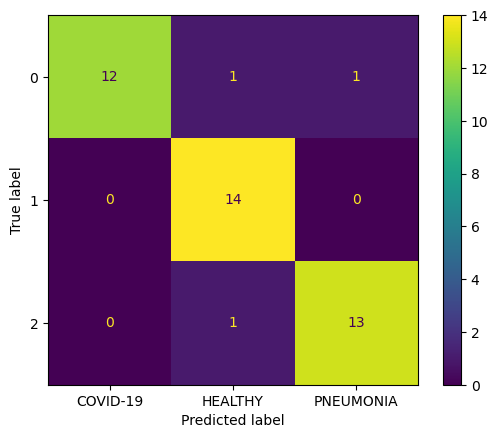

In [110]:
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)
plt.xticks(range(3), val_ds.class_names)
plt.show()

In [69]:
cnn_model3 = repeat_model()

results = cnn_model3.fit(train_ds, validation_data=val_ds, epochs=30, batch_size=32, callbacks=[early_stopping])

Epoch 1/30
11/11 [==============================] - 4s 277ms/step - loss: 1.0698 - accuracy: 0.3953 - val_loss: 0.9546 - val_accuracy: 0.5000
Epoch 2/30
11/11 [==============================] - 4s 273ms/step - loss: 0.8600 - accuracy: 0.5339 - val_loss: 0.7290 - val_accuracy: 0.6667
Epoch 3/30
11/11 [==============================] - 4s 276ms/step - loss: 0.6391 - accuracy: 0.7640 - val_loss: 0.5267 - val_accuracy: 0.8571
Epoch 4/30
11/11 [==============================] - 3s 248ms/step - loss: 0.4499 - accuracy: 0.8732 - val_loss: 0.3017 - val_accuracy: 0.9048
Epoch 5/30
11/11 [==============================] - 3s 251ms/step - loss: 0.3254 - accuracy: 0.8909 - val_loss: 0.2515 - val_accuracy: 0.9048
Epoch 6/30
11/11 [==============================] - 3s 257ms/step - loss: 0.2877 - accuracy: 0.8850 - val_loss: 0.3183 - val_accuracy: 0.9048
Epoch 7/30
11/11 [==============================] - 3s 251ms/step - loss: 0.2302 - accuracy: 0.9174 - val_loss: 0.1813 - val_accuracy: 0.9286
Epoch 

## CNN RGB

Same example as before, but working with RGB images instead.

In this case, we just need to specify we are receiving an input of (256, 256, 3).

In [16]:
train_rgb_ds = tf.keras.utils.image_dataset_from_directory('data/covid/train/', seed=42, shuffle=False)
val_rgb_ds = tf.keras.utils.image_dataset_from_directory('data/covid/validation/', seed=42, shuffle=False)
test_rgb_ds = tf.keras.utils.image_dataset_from_directory('data/covid/test/', seed=42, shuffle=False)

Found 339 files belonging to 3 classes.
Found 42 files belonging to 3 classes.
Found 45 files belonging to 3 classes.


In [37]:
cnn_model_rgb = Sequential([
    Input(shape=(256, 256, 3)),
    Rescaling(1./255),
    Conv2D(filters=16, kernel_size=2, strides=1, activation='relu'),
    Conv2D(filters=16, kernel_size=2, strides=1, activation='relu'),
    MaxPooling2D(pool_size=2, strides=None),
    Conv2D(filters=4, kernel_size=2, strides=1, activation='relu'),
    Conv2D(filters=4, kernel_size=2, strides=1, activation='relu'),
    MaxPooling2D(pool_size=2, strides=None),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

cnn_model_rgb.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

def repeat_model():
    cnn_model_rgb = Sequential([
        Input(shape=(256, 256, 3)),
        Rescaling(1./255),
        Conv2D(filters=16, kernel_size=2, strides=1, activation='relu'),
        Conv2D(filters=16, kernel_size=2, strides=1, activation='relu'),
        MaxPooling2D(pool_size=2, strides=None),
        Conv2D(filters=4, kernel_size=2, strides=1, activation='relu'),
        Conv2D(filters=4, kernel_size=2, strides=1, activation='relu'),
        MaxPooling2D(pool_size=2, strides=None),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(len(class_names), activation='softmax')
    ])

    cnn_model_rgb.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return cnn_model_rgb

In [146]:
cnn_model_rgb.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_39 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_144 (Conv2D)         (None, 255, 255, 16)      208       
                                                                 
 conv2d_145 (Conv2D)         (None, 254, 254, 16)      1040      
                                                                 
 max_pooling2d_72 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_146 (Conv2D)         (None, 126, 126, 4)       260       
                                                                 
 conv2d_147 (Conv2D)         (None, 125, 125, 4)       68        
                                                     

In [147]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=8)

# Fit the model with the EarlyStopping callback
results = cnn_model_rgb.fit(train_rgb_ds, validation_data=val_rgb_ds, epochs=50, batch_size=32, callbacks=[early_stopping])

Epoch 1/50
11/11 [==============================] - 4s 310ms/step - loss: 1.1600 - accuracy: 0.3127 - val_loss: 1.0989 - val_accuracy: 0.3333
Epoch 2/50
11/11 [==============================] - 3s 295ms/step - loss: 1.0990 - accuracy: 0.2271 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 3/50
11/11 [==============================] - 4s 307ms/step - loss: 1.0984 - accuracy: 0.3333 - val_loss: 1.0981 - val_accuracy: 0.3333
Epoch 4/50
11/11 [==============================] - 3s 299ms/step - loss: 1.0976 - accuracy: 0.3540 - val_loss: 1.0967 - val_accuracy: 0.4524
Epoch 5/50
11/11 [==============================] - 3s 297ms/step - loss: 1.0947 - accuracy: 0.4808 - val_loss: 1.0911 - val_accuracy: 0.5238
Epoch 6/50
11/11 [==============================] - 4s 306ms/step - loss: 1.0863 - accuracy: 0.5988 - val_loss: 1.0695 - val_accuracy: 0.5952
Epoch 7/50
11/11 [==============================] - 3s 299ms/step - loss: 1.0576 - accuracy: 0.5959 - val_loss: 1.0277 - val_accuracy: 0.3333
Epoch 

In [148]:
# Keras returns predicted probabilities by default

y_val_pred_probs_rgb = cnn_model_rgb.predict(val_rgb_ds)
y_val_pred_probs_rgb[:5]

2/2 [==============================] - 0s 23ms/step


array([[9.9998605e-01, 1.2886707e-05, 1.0273567e-06],
       [9.9999964e-01, 6.5089857e-08, 2.0653579e-07],
       [9.6693236e-01, 1.0235277e-02, 2.2832351e-02],
       [9.9992001e-01, 7.3852129e-07, 7.9218778e-05],
       [9.9928325e-01, 3.9704164e-04, 3.1968401e-04]], dtype=float32)

In [149]:
# Convert probabilities to class predictions
y_val_pred_rgb = y_val_pred_probs_rgb.argmax(axis=1)
y_val_pred_rgb[:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [150]:
accuracy = accuracy_score(y_val, y_val_pred_rgb)
precision = precision_score(y_val, y_val_pred_rgb, average='weighted')
recall =  recall_score(y_val, y_val_pred_rgb, average='weighted')

print("Val Accuracy", accuracy)
print("Val Precision:", precision)
print("Val Recall", recall)

Val Accuracy 0.9761904761904762
Val Precision: 0.9777777777777776
Val Recall 0.9761904761904762


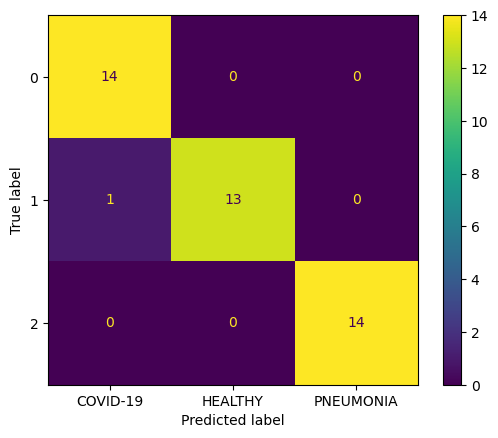

In [151]:
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred_rgb)
plt.xticks(range(3), val_ds.class_names)
plt.show()

### Dropout, Batch Normalizaction, Data Augmentation

In [17]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers

In [171]:
'''cnn_model_rgb2 = Sequential([
        Input(shape=(256, 256, 3)),
        Rescaling(1./255),
        #layers.RandomFlip("horizontal_and_vertical"),
        #layers.RandomRotation(0.1),
        # layers.RandomContrast(0.2),
        # layers.RandomBrightness(0.2),
        # layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
        Conv2D(filters=16, kernel_size=2, strides=1, activation='relu'),
        #Dropout(0.1),
        #BatchNormalization(),
        Conv2D(filters=16, kernel_size=2, strides=1, activation='relu'),
        MaxPooling2D(pool_size=2, strides=None),
        Conv2D(filters=4, kernel_size=2, strides=1, activation='relu'),
        Conv2D(filters=4, kernel_size=2, strides=1, activation='relu'),
        MaxPooling2D(pool_size=2, strides=None),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(len(class_names), activation='softmax')

    ])

cnn_model_rgb2.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])''' 
cnn_model_rgb2 = Sequential([
    Input(shape=(256, 256, 3)),
    Rescaling(1./255),
    #layers.RandomRotation(0.1),
    Conv2D(filters=16, kernel_size=2, strides=1, activation='relu'),
    Dropout(0.1),
    Conv2D(filters=16, kernel_size=2, strides=1, activation='relu'),
    Dropout(0.1),
    MaxPooling2D(pool_size=2, strides=None),
    Conv2D(filters=4, kernel_size=2, strides=1, activation='relu'),
    Dropout(0.1),
    Conv2D(filters=4, kernel_size=2, strides=1, activation='relu'),
    #Dropout(0.1),
    MaxPooling2D(pool_size=2, strides=None),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

cnn_model_rgb2.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


In [172]:
cnn_model_rgb2.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_43 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_168 (Conv2D)         (None, 255, 255, 16)      208       
                                                                 
 dropout_129 (Dropout)       (None, 255, 255, 16)      0         
                                                                 
 conv2d_169 (Conv2D)         (None, 254, 254, 16)      1040      
                                                                 
 dropout_130 (Dropout)       (None, 254, 254, 16)      0         
                                                                 
 max_pooling2d_82 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                     

In [173]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

# Fit the model with the EarlyStopping callback
results = cnn_model_rgb2.fit(train_rgb_ds, validation_data=val_rgb_ds, epochs=50, batch_size=64, callbacks=[early_stopping])

Epoch 1/50
11/11 [==============================] - 7s 588ms/step - loss: 2.3063 - accuracy: 0.2419 - val_loss: 1.1008 - val_accuracy: 0.3333
Epoch 2/50
11/11 [==============================] - 6s 569ms/step - loss: 1.0878 - accuracy: 0.1534 - val_loss: 1.1030 - val_accuracy: 0.3333
Epoch 3/50
11/11 [==============================] - 6s 573ms/step - loss: 1.2590 - accuracy: 0.3333 - val_loss: 1.0961 - val_accuracy: 0.3333
Epoch 4/50
11/11 [==============================] - 6s 559ms/step - loss: 1.1374 - accuracy: 0.3333 - val_loss: 1.0984 - val_accuracy: 0.4048
Epoch 5/50
11/11 [==============================] - 6s 561ms/step - loss: 1.0969 - accuracy: 0.3540 - val_loss: 1.0985 - val_accuracy: 0.4048
Epoch 6/50
11/11 [==============================] - 6s 561ms/step - loss: 1.0924 - accuracy: 0.3363 - val_loss: 1.0954 - val_accuracy: 0.4048
Epoch 7/50
11/11 [==============================] - 6s 568ms/step - loss: 1.0714 - accuracy: 0.4071 - val_loss: 1.0623 - val_accuracy: 0.3333
Epoch 

In [174]:
# Keras returns predicted probabilities by default

y_val_pred_probs_rgb2 = cnn_model_rgb2.predict(val_rgb_ds)
y_val_pred_probs_rgb2[:5]

2/2 [==============================] - 0s 23ms/step


array([[9.6170110e-01, 3.7706520e-02, 5.9239415e-04],
       [9.8620063e-01, 1.3745942e-02, 5.3354615e-05],
       [8.4168649e-01, 1.4221559e-01, 1.6097888e-02],
       [9.4077265e-01, 5.7575937e-02, 1.6513978e-03],
       [8.0161804e-01, 1.7162697e-01, 2.6754938e-02]], dtype=float32)

In [175]:
# Convert probabilities to class predictions
y_val_pred_rgb2 = y_val_pred_probs_rgb2.argmax(axis=1)
y_val_pred_rgb2[:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [176]:
accuracy = accuracy_score(y_val, y_val_pred_rgb2)
precision = precision_score(y_val, y_val_pred_rgb2, average='weighted')
recall =  recall_score(y_val, y_val_pred_rgb2, average='weighted')

print("Val Accuracy", accuracy)
print("Val Precision:", precision)
print("Val Recall", recall)

Val Accuracy 0.9523809523809523
Val Precision: 0.9539682539682539
Val Recall 0.9523809523809523


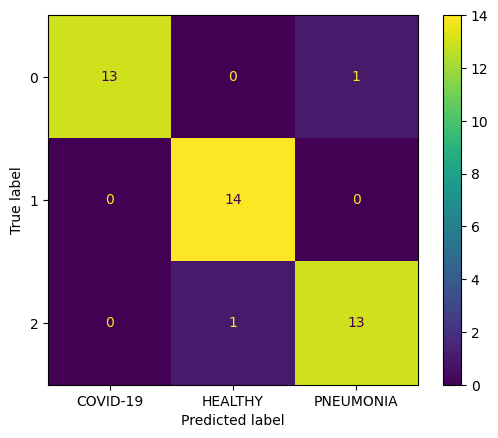

In [182]:
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred_rgb2)
plt.xticks(range(3), val_ds.class_names)
plt.show()

### MobileNetV2

In [183]:
from tensorflow.keras.applications import MobileNetV2

In [184]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(256,256,3)
)
for layer in base_model.layers:
    layer.trainable = False

In [192]:
mobil_model = Sequential()

## Resize teh images to 224x224
# mobil_model.add(Resizing(224,224))

mobil_model.add(Input(shape=(256,256,3)))

#Rescale the grayscale images
mobil_model.add(Rescaling(1./255))

# Expand the 1 channel input to 3 channels
# to match MobileNetV2 input requirements
#mobil_model.add(Conv2D(3, (3,3)))

# add all the MobileNetV2 layers    # aqui lo importas y el modelo de convulsiones y ya estaria
mobil_model.add(base_model)

# Add your custom layers
mobil_model.add(Flatten())
mobil_model.add(Dense(32, activation='relu'))
mobil_model.add(Dense(len(class_names), activation='softmax'))

# Compile the  model
mobil_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [193]:
mobil_model.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_47 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_47 (Flatten)        (None, 81920)             0         
                                                                 
 dense_99 (Dense)            (None, 32)                2621472   
                                                                 
 dense_100 (Dense)           (None, 3)                 99        
                                                                 
Total params: 4879555 (18.61 MB)
Trainable params: 2621571 (10.00 MB)
Non-trainable params: 2257984 (8.61 MB)
_________

In [194]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

# Fit the model with the EarlyStopping callback
results = mobil_model.fit(train_rgb_ds, validation_data=val_rgb_ds, epochs=50, batch_size=32, callbacks=[early_stopping])

Epoch 1/50
11/11 [==============================] - 9s 652ms/step - loss: 88.0942 - accuracy: 0.2625 - val_loss: 22.7918 - val_accuracy: 0.3333
Epoch 2/50
11/11 [==============================] - 7s 604ms/step - loss: 3.1723 - accuracy: 0.6224 - val_loss: 0.9034 - val_accuracy: 0.5952
Epoch 3/50
11/11 [==============================] - 6s 571ms/step - loss: 0.7780 - accuracy: 0.6401 - val_loss: 0.8095 - val_accuracy: 0.5952
Epoch 4/50
11/11 [==============================] - 6s 568ms/step - loss: 0.7791 - accuracy: 0.6313 - val_loss: 0.8084 - val_accuracy: 0.5952
Epoch 5/50
11/11 [==============================] - 6s 577ms/step - loss: 0.7810 - accuracy: 0.6254 - val_loss: 0.8072 - val_accuracy: 0.5952
Epoch 6/50
11/11 [==============================] - 6s 572ms/step - loss: 0.7728 - accuracy: 0.6313 - val_loss: 0.8059 - val_accuracy: 0.5952
Epoch 7/50
11/11 [==============================] - 6s 571ms/step - loss: 0.7594 - accuracy: 0.6401 - val_loss: 0.7979 - val_accuracy: 0.6190
Epoc

In [195]:
# Keras returns predicted probabilities by default

y_val_pred_probs_mobil = mobil_model.predict(val_rgb_ds)
y_val_pred_probs_mobil[:5]

2/2 [==============================] - 1s 146ms/step


array([[1.0000000e+00, 1.6306992e-17, 1.0707988e-08],
       [1.0000000e+00, 5.8161709e-32, 1.4045299e-15],
       [1.0000000e+00, 1.4211953e-29, 1.9278055e-14],
       [1.0000000e+00, 1.3040653e-25, 1.4882256e-12],
       [1.0000000e+00, 2.2287242e-16, 3.7212654e-08]], dtype=float32)

In [196]:
# Convert probabilities to class predictions
y_val_pred_mobil = y_val_pred_probs_mobil.argmax(axis=1)
y_val_pred_mobil[:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [197]:
accuracy = accuracy_score(y_val, y_val_pred_mobil)
precision = precision_score(y_val, y_val_pred_mobil, average='weighted')
recall =  recall_score(y_val, y_val_pred_mobil, average='weighted')

print("Val Accuracy", accuracy)
print("Val Precision:", precision)
print("Val Recall", recall)

Val Accuracy 0.6190476190476191
Val Precision: 0.4888888888888888
Val Recall 0.6190476190476191


c:\Users\Alumne_mati1\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


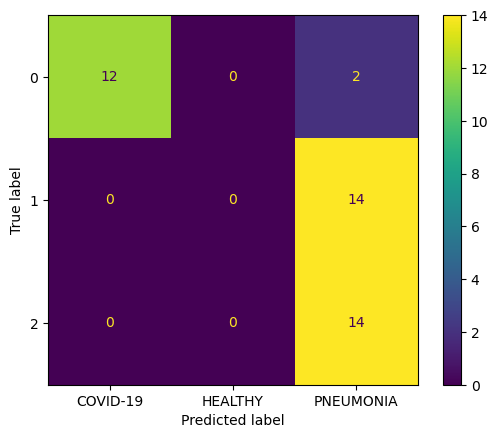

In [198]:
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred_mobil)
plt.xticks(range(3), val_ds.class_names)
plt.show()

## RandomSearch NN

### 1 Try

In [18]:
from kerastuner.tuners import RandomSearch

C:\Users\Alumne_mati1\AppData\Local\Temp\ipykernel_18056\2610907151.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [18]:
# Define la función para construir el modelo
def build_model(hp):
    model_rs = Sequential()
    model_rs.add(Input(shape=(256, 256, 3)))
    model_rs.add(Rescaling(1./255))
    
    # Agrega capas convolucionales y de pooling
    for i in range(hp.Int('conv_layers', min_value=1, max_value=4)):
        model_rs.add(Conv2D(filters=hp.Int('filters_' + str(i), min_value=8, max_value=64, step=8),
                                kernel_size=hp.Choice('kernel_size_' + str(i), values=[2, 3]),
                                strides=1,
                                activation='relu'))
        model_rs.add(MaxPooling2D(pool_size=2, strides=None))    
    model_rs.add(Flatten())
    
    # Agrega capas densas
    for i in range(hp.Int('dense_layers', min_value=1, max_value=3)):
        model_rs.add(Dense(units=hp.Int('units_' + str(i), min_value=16, max_value=128, step=16),
                               activation='relu'))
    
    model_rs.add(Dense(len(class_names), activation='softmax'))
    
    model_rs.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.1, 0.01, 0.001])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model_rs

In [19]:
# Configura el tuner de búsqueda aleatoria
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    overwrite=True,    #para que sobrescriba los hyperparametros
)

#results = mobil_model.fit(train_rgb_ds, validation_data=val_rgb_ds, epochs=50, batch_size=32, callbacks=[early_stopping])
# Realiza la búsqueda de hiperparámetros
tuner.search(train_rgb_ds, epochs=10, validation_data=val_rgb_ds)

# Obtiene los mejores hiperparámetros encontrados
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps}")

# Construye y entrena el modelo con los mejores hiperparámetros
model_rs = tuner.hypermodel.build(best_hps)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
results = model_rs.fit(train_rgb_ds, validation_data=val_rgb_ds, epochs=50, batch_size=32, callbacks=[early_stopping])

Trial 10 Complete [00h 00m 36s]
val_accuracy: 0.3333333432674408

Best val_accuracy So Far: 0.8809523582458496
Total elapsed time: 00h 28m 56s
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x000001D0072A5E50>
Epoch 1/50
11/11 [==============================] - 9s 714ms/step - loss: 26.5549 - accuracy: 0.4897 - val_loss: 39.3375 - val_accuracy: 0.3333
Epoch 2/50
11/11 [==============================] - 8s 707ms/step - loss: 38.3596 - accuracy: 0.0000e+00 - val_loss: 8.8559 - val_accuracy: 0.3333
Epoch 3/50
11/11 [==============================] - 8s 706ms/step - loss: 2.6206 - accuracy: 0.4572 - val_loss: 3.4348 - val_accuracy: 0.3333
Epoch 4/50
11/11 [==============================] - 8s 709ms/step - loss: 4.4954 - accuracy: 0.3628 - val_loss: 1.4259 - val_accuracy: 0.5714
Epoch 5/50
11/11 [==============================] - 8s 731ms/step - loss: 1.2689 - accuracy: 0.3540 - val_loss: 0.6812 - val_accuracy: 0.7619
Epoch 6/50
11/11

In [27]:
best_hps

In [29]:
# Imprimir la estructura de la red neuronal
model_rs.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 255, 255, 32)      416       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 516128)            0         
                                                                 
 dense_2 (Dense)             (None, 80)                41290320  
                                                                 
 dense_3 (Dense)             (None, 112)               9072      
                                                      

In [20]:
# Keras returns predicted probabilities by default

y_val_pred_probs_rs = model_rs.predict(val_rgb_ds)
y_val_pred_probs_rs[:5]

2/2 [==============================] - 0s 35ms/step


array([[9.9930537e-01, 4.3510128e-04, 2.5959910e-04],
       [9.9999392e-01, 4.7377416e-06, 1.3206831e-06],
       [9.7881383e-01, 3.7786672e-03, 1.7407464e-02],
       [9.9921393e-01, 1.6031630e-04, 6.2568428e-04],
       [9.8450691e-01, 1.9959530e-03, 1.3497104e-02]], dtype=float32)

In [21]:
# Convert probabilities to class predictions
y_val_pred_rs = y_val_pred_probs_rs.argmax(axis=1)
y_val_pred_rs[:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [22]:
accuracy = accuracy_score(y_val, y_val_pred_rs)
precision = precision_score(y_val, y_val_pred_rs, average='weighted')
recall =  recall_score(y_val, y_val_pred_rs, average='weighted')

print("Val Accuracy", accuracy)
print("Val Precision:", precision)
print("Val Recall", recall)

Val Accuracy 0.9285714285714286
Val Precision: 0.9317460317460318
Val Recall 0.9285714285714286


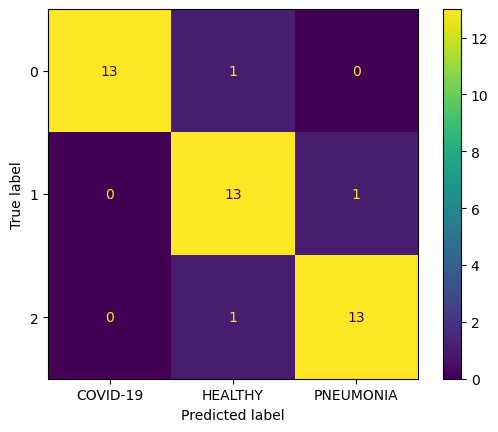

In [23]:
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred_rs)
plt.xticks(range(3), val_ds.class_names)
plt.show()

### 2 Try

In [30]:
# Define la función para construir el modelo
def build_model2(hp):
    model_rs = Sequential()
    model_rs.add(Input(shape=(256, 256, 3)))
    model_rs.add(Rescaling(1./255))
    
    # Agrega capas convolucionales y de pooling
    for i in range(hp.Int('conv_layers', min_value=1, max_value=4)):
        model_rs.add(Conv2D(filters=hp.Int('filters_' + str(i), min_value=8, max_value=64, step=8),
                                kernel_size=hp.Choice('kernel_size_' + str(i), values=[2, 3]),
                                strides=1,
                                activation='relu'))
        dropout_value = hp.Choice('dropout_value', values=[0.1, 0.2])
        if dropout_value == 0.1:
            model_rs.add(Dropout(0.1))
        else:
            model_rs.add(Dropout(0.2))
        model_rs.add(MaxPooling2D(pool_size=2, strides=None))    
    model_rs.add(Flatten())
    
    # Agrega capas densas
    for i in range(hp.Int('dense_layers', min_value=1, max_value=3)):
        model_rs.add(Dense(units=hp.Int('units_' + str(i), min_value=16, max_value=128, step=16),
                               activation='relu'))
    
    model_rs.add(Dense(len(class_names), activation='softmax'))
    
    model_rs.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.1, 0.01, 0.001])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model_rs

In [31]:
# Configura el tuner de búsqueda aleatoria
tuner = RandomSearch(
    build_model2,
    objective='val_accuracy',
    max_trials=10,
)

#results = mobil_model.fit(train_rgb_ds, validation_data=val_rgb_ds, epochs=50, batch_size=32, callbacks=[early_stopping])
# Realiza la búsqueda de hiperparámetros
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
tuner.search(train_rgb_ds, epochs=10, validation_data=val_rgb_ds, callbacks=[early_stopping])

# Obtiene los mejores hiperparámetros encontrados
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps}")

# Construye y entrena el modelo con los mejores hiperparámetros
model_rs2 = tuner.hypermodel.build(best_hps)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
results = model_rs2.fit(train_rgb_ds, validation_data=val_rgb_ds, epochs=50, batch_size=32, callbacks=[early_stopping])

Reloading Tuner from .\untitled_project\tuner0.json
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x000001D00BD71990>
Epoch 1/50
11/11 [==============================] - 12s 974ms/step - loss: 23.4298 - accuracy: 0.5074 - val_loss: 69.0505 - val_accuracy: 0.3333
Epoch 2/50
11/11 [==============================] - 11s 964ms/step - loss: 67.2160 - accuracy: 0.0088 - val_loss: 8.1610 - val_accuracy: 0.4524
Epoch 3/50
11/11 [==============================] - 11s 965ms/step - loss: 6.1359 - accuracy: 0.0708 - val_loss: 1.7677 - val_accuracy: 0.3333
Epoch 4/50
11/11 [==============================] - 11s 954ms/step - loss: 2.3413 - accuracy: 0.1180 - val_loss: 0.5885 - val_accuracy: 0.6190
Epoch 5/50
11/11 [==============================] - 11s 953ms/step - loss: 1.2279 - accuracy: 0.5457 - val_loss: 1.0096 - val_accuracy: 0.5952
Epoch 6/50
11/11 [==============================] - 11s 972ms/step - loss: 1.9308 - accuracy: 0.4897 - val

In [32]:
# Imprimir la estructura de la red neuronal
model_rs2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 255, 255, 32)      416       
                                                                 
 dropout (Dropout)           (None, 255, 255, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 516128)            0         
                                                                 
 dense_6 (Dense)             (None, 80)                41290320  
                                                      

In [33]:
# Keras returns predicted probabilities by default

y_val_pred_probs_rs2 = model_rs2.predict(val_rgb_ds)
y_val_pred_probs_rs2[:5]

2/2 [==============================] - 0s 35ms/step


array([[9.9968839e-01, 2.8691947e-04, 2.4678575e-05],
       [9.9999404e-01, 5.8856481e-06, 1.6388375e-07],
       [9.9509394e-01, 2.7438500e-03, 2.1622060e-03],
       [9.9903440e-01, 5.0168746e-04, 4.6386427e-04],
       [9.9757296e-01, 1.4905150e-03, 9.3648932e-04]], dtype=float32)

In [34]:
# Convert probabilities to class predictions
y_val_pred_rs2 = y_val_pred_probs_rs2.argmax(axis=1)
y_val_pred_rs2[:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [35]:
accuracy = accuracy_score(y_val, y_val_pred_rs2)
precision = precision_score(y_val, y_val_pred_rs2, average='weighted')
recall =  recall_score(y_val, y_val_pred_rs2, average='weighted')

print("Val Accuracy", accuracy)
print("Val Precision:", precision)
print("Val Recall", recall)

Val Accuracy 0.9523809523809523
Val Precision: 0.9523809523809523
Val Recall 0.9523809523809523


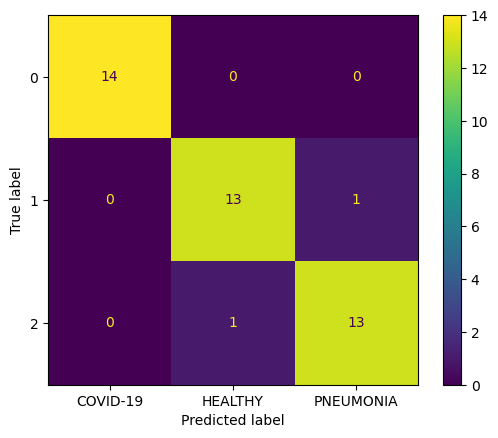

In [36]:
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred_rs2)
plt.xticks(range(3), val_ds.class_names)
plt.show()

### 3 Try

In [28]:
# Define la función para construir el modelo
def build_model3(hp):
    model_rs = Sequential()
    model_rs.add(Input(shape=(256, 256, 3)))
    model_rs.add(Rescaling(1./255))
    
    # Agrega capas convolucionales y de pooling
    for i in range(hp.Int('conv_layers', min_value=1, max_value=5)):
        model_rs.add(Conv2D(filters=hp.Int('filters_' + str(i), min_value=8, max_value=64, step=8),
                                kernel_size=hp.Choice('kernel_size_' + str(i), values=[2, 3]),
                                strides=1,
                                activation='relu'))
        dropout_value = hp.Choice('dropout_value', values=[0.1, 0.2, 0.0])
        if dropout_value == 0.1:
            model_rs.add(Dropout(0.1))
        elif dropout_value == 0:
            model_rs.add(Dropout(0.0))
        else:
            model_rs.add(Dropout(0.2))
        model_rs.add(MaxPooling2D(pool_size=2, strides=None))    
    model_rs.add(Flatten())
    
    # Agrega capas densas
    for i in range(hp.Int('dense_layers', min_value=1, max_value=3)):
        model_rs.add(Dense(units=hp.Int('units_' + str(i), min_value=16, max_value=128, step=16),
                               activation='relu'))
    
    model_rs.add(Dense(len(class_names), activation='softmax'))
    
    model_rs.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.1, 0.01, 0.001])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model_rs

In [35]:
# Configura el tuner de búsqueda aleatoria
tuner2 = RandomSearch(
    build_model3,
    objective='val_accuracy',
    max_trials=50,
    #overwrite=True     #esto para que empiece de 0 los trials y sobrescriba los hyperparametros, si no lo pones te sigue por donde iba
)

#results = mobil_model.fit(train_rgb_ds, validation_data=val_rgb_ds, epochs=50, batch_size=32, callbacks=[early_stopping])
# Realiza la búsqueda de hiperparámetros
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
tuner2.search(train_rgb_ds, epochs=10, validation_data=val_rgb_ds, callbacks=[early_stopping])

# Obtiene los mejores hiperparámetros encontrados
best_hps = tuner2.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps}")

# Construye y entrena el modelo con los mejores hiperparámetros
model_rs3 = tuner2.hypermodel.build(best_hps)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
results = model_rs3.fit(train_rgb_ds, validation_data=val_rgb_ds, epochs=50, batch_size=32, callbacks=[early_stopping])

Reloading Tuner from .\untitled_project\tuner0.json
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x000001F4FD3CE250>
Epoch 1/50
11/11 [==============================] - 5s 358ms/step - loss: 13.7463 - accuracy: 0.3953 - val_loss: 3.4801 - val_accuracy: 0.3333
Epoch 2/50
11/11 [==============================] - 4s 344ms/step - loss: 5.5668 - accuracy: 0.0000e+00 - val_loss: 1.5438 - val_accuracy: 0.3333
Epoch 3/50
11/11 [==============================] - 4s 345ms/step - loss: 1.2734 - accuracy: 0.1003 - val_loss: 1.0489 - val_accuracy: 0.5476
Epoch 4/50
11/11 [==============================] - 4s 340ms/step - loss: 1.1714 - accuracy: 0.6431 - val_loss: 1.0931 - val_accuracy: 0.4762
Epoch 5/50
11/11 [==============================] - 4s 341ms/step - loss: 1.1286 - accuracy: 0.2832 - val_loss: 1.0656 - val_accuracy: 0.6667
Epoch 6/50
11/11 [==============================] - 4s 342ms/step - loss: 1.0329 - accuracy: 0.6932 - val_los

In [36]:
model_rs3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 254, 254, 8)       224       
                                                                 
 dropout_7 (Dropout)         (None, 254, 254, 8)       0         
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 127, 127, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 125, 125, 24)      1752      
                                                                 
 dropout_8 (Dropout)         (None, 125, 125, 24)      0         
                                                      

In [37]:
# Keras returns predicted probabilities by default

y_val_pred_probs_rs3 = model_rs3.predict(val_rgb_ds)
y_val_pred_probs_rs3[:5]

2/2 [==============================] - 0s 15ms/step


array([[0.9416136 , 0.04375633, 0.01462998],
       [0.8905894 , 0.03937836, 0.07003219],
       [0.45537856, 0.27200487, 0.27261654],
       [0.9453058 , 0.02018059, 0.03451354],
       [0.71501285, 0.16819894, 0.11678826]], dtype=float32)

In [38]:
# Convert probabilities to class predictions
y_val_pred_rs3 = y_val_pred_probs_rs3.argmax(axis=1)
y_val_pred_rs3[:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [39]:
accuracy = accuracy_score(y_val, y_val_pred_rs3)
precision = precision_score(y_val, y_val_pred_rs3, average='weighted')
recall =  recall_score(y_val, y_val_pred_rs3, average='weighted')

print("Val Accuracy", accuracy)
print("Val Precision:", precision)
print("Val Recall", recall)

Val Accuracy 0.9047619047619048
Val Precision: 0.907051282051282
Val Recall 0.9047619047619048


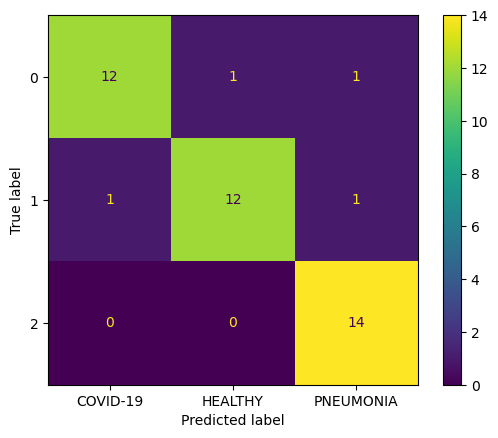

In [40]:
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred_rs3)
plt.xticks(range(3), val_ds.class_names)
plt.show()

# Save NN Keras Model 

In [17]:
from tensorflow.keras.models import load_model

In [39]:
cnn_model_rgb.save("cnn_model_rgb.keras")

In [40]:
neural_net = load_model("cnn_model_rgb.keras")